In [1]:
import sys
import os
import tensorflow as tf
import numpy as np
sys.path.append(".")
sys.path.append("./utils")
from custom_lbfgs import *
from SSAutil import *
from neuralnetwork import NeuralNetwork, MinmaxScaleLayer, UpScaleLayer
from SSA_equations.SSANN import SSAInformedNN
from logger import Logger
from plotting import *
import matplotlib.pyplot as plt

In [2]:
# Manually making sure the numpy random seeds are "the same" on all devices
np.random.seed(1234)
tf.random.set_seed(1234)

# Hyper parameters {{{
hp = {}
# Data size on the solution u
hp["N_u"] = 3000
# Collocation points size, where we’ll check for f = 0
hp["N_f"] = 1000
# DeepNN topology (2-sized input [x t], 8 hidden layer of 20-width, 1-sized output [u]
hp["layers"] = [2, 20, 20, 20, 20, 20, 20, 20, 20, 2]
#hp["C_layers"] = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]
# Setting up the TF SGD-based optimizer (set tf_epochs=0 to cancel it)
hp["tf_epochs"] = 100000
hp["tf_lr"] = 0.001
hp["tf_b1"] = 0.99
hp["tf_eps"] = 1e-1
# Setting up the quasi-newton LBGFS optimizer (set nt_epochs=0 to cancel it)
hp["nt_epochs"] = 0
hp["nt_lr"] = 0.8
hp["nt_ncorr"] = 50
hp["log_frequency"] = 1000
hp["use_tfp"] = False
# Record the history
hp["save_history"] = True
# path for loading data and saving models
repoPath = "./"
appDataPath = os.path.join(repoPath, "matlab_SSA", "DATA")
path = os.path.join(appDataPath, "Helheim_Weertman_iT080_PINN.mat")
modelPath = "./Models/Helheim"
reloadModel = False # reload from previous training
#}}}

In [3]:
# load the data
x, y, Exact_vx, Exact_vy, X_star, u_star, X_u_train, u_train, X_f, X_bc, u_bc, X_cf, n_cf, xub, xlb, uub, ulb = prep_Helheim_data(path, hp["N_u"], hp["N_f"])

# Creating the model and training
logger = Logger(hp)
pinn = SSAInformedNN(hp, logger, X_f, 
        X_bc, u_bc,
        X_cf, n_cf,
        xub, xlb, uub, ulb, 
        modelPath, reloadModel,
        eta=1.8157e8, 
        loss_weights=[1e-2, 1e-8, 1e-12],
        geoDataNN="./Models/Helheim_H_bed/", 
        FrictionCNN="./Models/Helheim_C/")

X_u = pinn.tensor(X_u_train)
u = pinn.tensor(u_train)
# error function for logger
def error():
    return pinn.test_error(X_u, u)
logger.set_error_fn(error)

Hyperparameters:
{
  "N_u": 3000,
  "N_f": 1000,
  "layers": [
    2,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    2
  ],
  "tf_epochs": 100000,
  "tf_lr": 0.001,
  "tf_b1": 0.99,
  "tf_eps": 0.1,
  "nt_epochs": 0,
  "nt_lr": 0.8,
  "nt_ncorr": 50,
  "log_frequency": 1000,
  "use_tfp": false,
  "save_history": true
}

TensorFlow version: 2.4.1
Eager execution: True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU-accerelated: True


In [4]:
# train the model
#pinn.fit(X_star, u_star)
pinn.fit(X_bc, u_bc)

# save
#pinn.model.save("./Models/SSA2D_friction_1e_4_TF"+str(hp["tf_epochs"]) +"_NT"+str(hp["nt_epochs"]))


Training started
-- Starting Adam optimization --
tf_epoch =      0  elapsed = 00:19 (+19.7)  loss = 1.9070e+05  
tf_epoch =   1000  elapsed = 00:42 (+23.2)  loss = 2.1168e+04  
tf_epoch =   2000  elapsed = 01:06 (+23.1)  loss = 2.0389e+04  
tf_epoch =   3000  elapsed = 01:29 (+23.1)  loss = 1.8599e+04  
tf_epoch =   4000  elapsed = 01:52 (+23.3)  loss = 1.2265e+04  
tf_epoch =   5000  elapsed = 02:15 (+23.1)  loss = 1.0104e+04  
tf_epoch =   6000  elapsed = 02:38 (+23.1)  loss = 9.4153e+03  
tf_epoch =   7000  elapsed = 03:02 (+23.1)  loss = 7.8214e+03  
tf_epoch =   8000  elapsed = 03:25 (+23.1)  loss = 1.0438e+04  
tf_epoch =   9000  elapsed = 03:48 (+23.1)  loss = 7.0403e+03  
tf_epoch =  10000  elapsed = 04:11 (+23.1)  loss = 6.5896e+03  
tf_epoch =  11000  elapsed = 04:34 (+23.1)  loss = 5.6854e+03  
tf_epoch =  12000  elapsed = 04:57 (+23.1)  loss = 5.5687e+03  
tf_epoch =  13000  elapsed = 05:21 (+23.1)  loss = 5.3248e+03  
tf_epoch =  14000  elapsed = 05:44 (+23.1)  loss = 5.

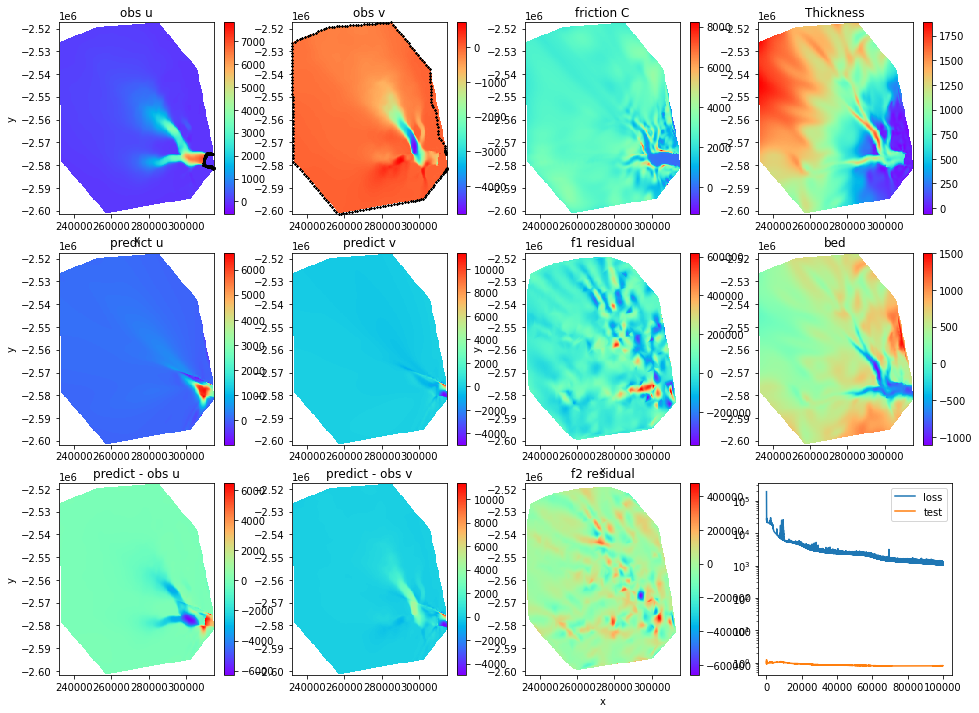

In [5]:
# plot
#plot_Helheim(pinn, X_f, X_u_train, u_train, xlb, xub)
plot_Helheim(pinn, X_f, X_star, u_star, xlb, xub)

# fit the data
#pinn.fit(X_u_train, u_train)
#u_pred, v_pred = pinn.predict(X_star)

# test
#plot_H_bed(pinn, X_star, u_star, xlb, xub)